<a href="https://colab.research.google.com/github/zahta/machine-learning/blob/master/hyperparameters-optimization/hyperparameter_tuning_pytorch_ray_tune_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Hyperparameter Tuning of a [PyTorch](https://pytorch.org/) Neural Network with [Ray Tune](https://docs.ray.io/en/latest/tune/index.html)

### By [Zahra Taheri](https://github.com/zahta) May 25, 2022

# Prepration of the regression dataset [California Housing Values](https://github.com/ageron/handson-ml/tree/master/datasets/housing)

## Imports

In [ ]:
#For some basic operations
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

#For visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Mount google drive to read from files and write to files

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Reading the dataset

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/opt_class/housing.csv')
data.shape

(20640, 10)

In [ ]:
data.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Descriptive statistics and data visualizations

In [ ]:
#Describe the dataset

data.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [ ]:
#Check the no. of unique items in each categorical column

data.select_dtypes('object').nunique()

ocean_proximity    5
dtype: int64

In [ ]:
# Percentage of missing data in each column

number_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/number_of_columns
print(percentage_of_missing_data)

longitude             0.000000
latitude              0.000000
housing_median_age    0.000000
total_rooms           0.000000
total_bedrooms        0.010029
population            0.000000
households            0.000000
median_income         0.000000
median_house_value    0.000000
ocean_proximity       0.000000
dtype: float64


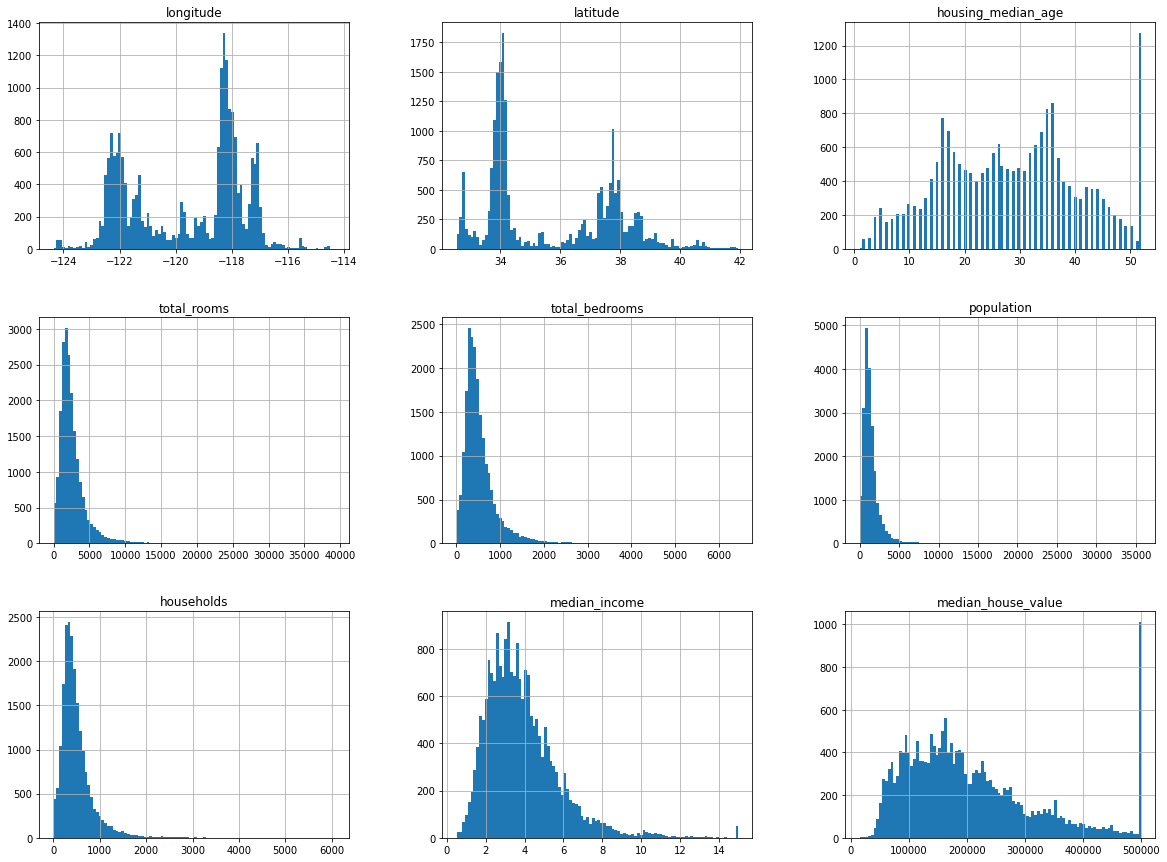

In [ ]:
data.hist(bins=100, figsize=(20,15))

plt.show()

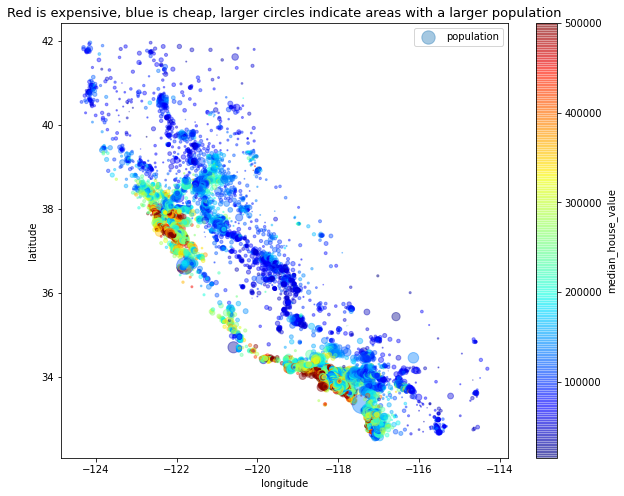

In [ ]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=data["population"]/100, label="population", figsize=(10,8),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.title('Red is expensive, blue is cheap, larger circles indicate areas with a larger population',\
          fontweight = 20, fontsize = 13)
plt.legend()

In [ ]:
corr_matrix = data.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Data cleaning and preparation

In [ ]:
#Fill in missing values with median

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [ ]:
#Remove the text attribute because median can only be calculated on numerical attributes:
data_num=data.drop("ocean_proximity", axis=1)

In [ ]:
imputer.fit(data_num)
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05])

In [ ]:
X = imputer.transform(data_num)
data_num_clean = pd.DataFrame(X, columns=data_num.columns,index=data_num.index)
data_num_clean.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  
0       322.0       126.0         8.3252            452600.0  
1      2401.0      1138.0         8.3014            358500.0  
2       496.0       177.0         7.2574            352100.0  
3       558.0       219.0         5.6431            341300.0  
4       565.0       259.0         3.8462            342200.0

In [ ]:
data_num_clean["rooms_per_household"] = data_num_clean["total_rooms"]/data_num_clean["households"]
data_num_clean["bedrooms_per_room"] = data_num_clean["total_bedrooms"]/data_num_clean["total_rooms"]
data_num_clean["population_per_household"]=data_num_clean["population"]/data_num_clean["households"]

In [ ]:
#Preprocess the categorical input feature, `ocean_proximity`:
data_cat = data[["ocean_proximity"]]

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
data_cat_encoded = ordinal_encoder.fit_transform(data_cat)

In [ ]:
data_num_clean["ocean_proximity"]=data_cat_encoded
data_clean=data_num_clean
data_clean.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  \
0       322.0       126.0         8.3252            452600.0   
1      2401.0      1138.0         8.3014            358500.0   
2       496.0       177.0         7.2574            352100.0   
3       558.0       219.0         5.6431            341300.0   
4       565.0       259.0         3.8462            342200.0   

   rooms_per_household  bedrooms_per_room  population_per_household  \
0             6.984127           0.146591                  2.555556   
1             6.238137           0.155797                  2.109842   
2             8.288136           0.129516                  2.802260   
3             5.817352           0.184458                  2.547945   
4             6.281853           0.172096                  2.181467   

   ocean_proximity  
0              3.0  
1              3.0  
2              3.0  
3              3.0  
4              3.0

In [ ]:
housing_labels = data_clean["median_house_value"]
data_clean = data_clean.drop("median_house_value", axis=1)
data_clean["median_house_value"] = housing_labels
data_clean

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  rooms_per_household  \
0           322.0       126.0         8.3252             6.984127   
1          2401.0      1138.0         8.3014             6.238137   
2           496.0       177.0         7.2574             8.288136   
3           558.0       219.0         5.6431             5.817352   
4           565.0       259.0         3.8462             6.281853   
...           ...         ...            ...                  ...   
20635       845.0       330.0         1.5603             5.045455   
20636       356.0       114.0         2.5568             6.114035   
20637      1007.0       433.0         1.7000             5.205543   
20638       741.0       349.0         1.8672             5.329513   
20639      1387.0       530.0         2.3886             5.254717   

       bedrooms_per_room  population_per_household  ocean_proximity  \
0               0.146591                  2.555556              3.0   
1               0.155797                  2.109842              3.0   
2               0.129516                  2.802260              3.0   
3               0.184458                  2.547945              3.0   
4               0.172096                  2.181467              3.0   
...                  ...                       ...              ...   
20635           0.224625                  2.560606              1.0   
20636           0.215208                  3.122807              1.0   
20637           0.215173                  2.325635              1.0   
20638           0.219892                  2.123209              1.0   
20639           0.221185                  2.616981              1.0   

       median_house_value  
0                452600.0  
1                358500.0  
2                352100.0  
3                341300.0  
4                342200.0  
...                   ...  
20635             78100.0  
20636             77100.0  
20637             92300.0  
20638             84700.0  
20639             89400.0  

[20640 rows x 13 columns]

In [ ]:
#Splitting the dependent and independent variables

X = data_clean.iloc[:,:-1]
y = data_clean.iloc[:,-1]

print(X.shape)
print(y.shape)

(20640, 12)
(20640,)


In [ ]:
#Splitting the dataset into training and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)

(16512, 12) (16512,) (4128, 12) (4128,)


In [ ]:
type(train_labels)

pandas.core.series.Series

In [ ]:
train_labels

14196    103000.0
8267     382100.0
17445    172600.0
14265     93400.0
2271      96500.0
           ...   
11284    229200.0
11964     97800.0
5390     222100.0
860      283500.0
15795    325000.0
Name: median_house_value, Length: 16512, dtype: float64

In [ ]:
from sklearn import preprocessing

scaler_data = preprocessing.MinMaxScaler()
train_data = scaler_data.fit_transform(train_data)
test_data = scaler_data.transform(test_data)

scaler_labels = preprocessing.MinMaxScaler()
train_labels_before = train_labels.values.reshape(-1, 1)
train_labels = scaler_labels.fit_transform(train_labels.values.reshape(-1, 1))
test_labels = scaler_labels.transform(test_labels.values.reshape(-1, 1))

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape)
print("Train labels before scaling: {} {} {}Train labels after scaling: {} {}".format('\n',train_labels_before,'\n', '\n', train_labels))

(16512, 12) (16512, 1) (4128, 12) (4128, 1)
Train labels before scaling: 
 [[103000.]
 [382100.]
 [172600.]
 ...
 [222100.]
 [283500.]
 [325000.]] 
Train labels after scaling: 
 [[0.18144461]
 [0.75690616]
 [0.32494918]
 ...
 [0.42701061]
 [0.55360803]
 [0.63917468]]


## Preparation of the dataset for PyTorch (PyTorch dataset)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transform to torch tensor

tensor_x = torch.tensor(train_data, dtype=torch.float).to(device) 
tensor_x2 = torch.tensor(test_data, dtype=torch.float).to(device) 

tensor_y = torch.tensor(train_labels, dtype=torch.float).to(device)
tensor_y2 = torch.tensor(test_labels, dtype=torch.float).to(device)

In [ ]:
# create your dataset

trainset = TensorDataset(tensor_x, tensor_y) 
testset = TensorDataset(tensor_x2,tensor_y2)

In [ ]:
trainset[0]

(tensor([0.7291, 0.0170, 0.6275, 0.0795, 0.0971, 0.0644, 0.1023, 0.1903, 0.0293,
         0.1118, 0.0024, 1.0000]), tensor([0.1814]))


# Hyperparameter optimization with Ray Tune

## Installation and imports for PyTorch models and Ray Tune

### Install Ray 

**Execute the following command for a minimal install**

`pip install -U ray `

**To install Ray with support for the dashboard + cluster launcher, run**

`pip install -U "ray[default]"`

**Most of the imports are needed for building the PyTorch model. Only the last three imports are for Ray Tune.**


In [ ]:
%%capture
try:
    import ray
except:
    !pip install -U ray
    import ray

In [ ]:
from functools import partial
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchsummary import summary

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [ ]:
# Function is useful when we want to read the dataset from a file and to share a data directory 
# between different trials (specially when we are working with a large dataset).

def load_data(data_dir=None):
    return trainset, testset

## Configurable neural network




### A FNN with 3 layers without activation function

In [ ]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.hidden_dim1 = int(self.config.get("hidden_dim1",100))
        self.hidden_dim2 = int(self.config.get("hidden_dim2",100))

        self.linear1 = nn.Linear(12, self.hidden_dim1)
        self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.linear3 = nn.Linear(self.hidden_dim2, 1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        out = self.linear3(out)
        return out

In [ ]:
model = Net({})

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
summary(model, (1,tensor_x.shape[1]))

count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           1,300
            Linear-2               [-1, 1, 100]          10,100
            Linear-3                 [-1, 1, 1]             101
Total params: 11,501
Trainable params: 11,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.05
----------------------------------------------------------------
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.weight |    1200    |
|  linear1.bias  |    100     |
| linear2.weight |   10000    |
|  linear2.bias  |    100     |
| linear3.weight |    100     |
|  linear3.bias  |     1      |
+----------------+------------+
Total Trainable Params: 11501


11501

### A FNN with 4 layers with some fixed activation function
https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [ ]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.hidden_dim1 = int(self.config.get("hidden_dim1", 100))
        self.hidden_dim2 = int(self.config.get("hidden_dim2", 100))
        self.hidden_dim3 = int(self.config.get("hidden_dim3", 100))

        self.linear1 = nn.Linear(12, self.hidden_dim1)
        self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.linear3 = nn.Linear(self.hidden_dim2, self.hidden_dim3)
        self.linear4 = nn.Linear(self.hidden_dim3, 1)

        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        self.act3 = nn.ReLU()
        
    def forward(self, x):
        output = self.linear1(x)
        output = self.act1(output)
        output = self.linear2(output)
        output = self.act2(output)
        output = self.linear3(output)
        output = self.act3(output)
        output = self.linear4(output)        
        return output

In [ ]:
model = Net({})

In [ ]:
summary(model, (1,tensor_x.shape[1]))

count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           1,300
              ReLU-2               [-1, 1, 100]               0
            Linear-3               [-1, 1, 100]          10,100
              Tanh-4               [-1, 1, 100]               0
            Linear-5               [-1, 1, 100]          10,100
              ReLU-6               [-1, 1, 100]               0
            Linear-7                 [-1, 1, 1]             101
Total params: 21,601
Trainable params: 21,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.09
----------------------------------------------------------------
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.we

21601

### A FNN with 4 layers and tunable fixed activation 
Note that we use this neural network for hyperparameter tuning

In [ ]:
class Net(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.hidden_dim1 = int(self.config.get("hidden_dim1", 100))
        self.hidden_dim2 = int(self.config.get("hidden_dim2", 100))
        self.hidden_dim3 = int(self.config.get("hidden_dim3", 100))

        self.act1 = self.config.get("act1", "relu") 
        self.act2 = self.config.get("act2", "relu") 
        self.act3 = self.config.get("act3", "relu")

        self.linear1 = nn.Linear(12, self.hidden_dim1)
        self.linear2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.linear3 = nn.Linear(self.hidden_dim2, self.hidden_dim3)
        self.linear4 = nn.Linear(self.hidden_dim3, 1)
    
    @staticmethod
    def activation_func(act_str):
        if act_str=="tanh":
            return eval("torch."+act_str)
        elif act_str=="selu" or act_str=="relu":   
            return eval("torch.nn.functional."+act_str)

    def forward(self, x):
        output = self.linear1(x)
        output = self.activation_func(self.act1)(output)
        output = self.linear2(output)
        output = self.activation_func(self.act2)(output)
        output = self.linear3(output)
        output = self.activation_func(self.act3)(output)
        output = self.linear4(output)        
        return output

In [ ]:
model = Net({})

In [ ]:
summary(model, (1,tensor_x.shape[1]))

count_parameters(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 100]           1,300
            Linear-2               [-1, 1, 100]          10,100
            Linear-3               [-1, 1, 100]          10,100
            Linear-4                 [-1, 1, 1]             101
Total params: 21,601
Trainable params: 21,601
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------
+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| linear1.weight |    1200    |
|  linear1.bias  |    100     |
| linear2.weight |   10000    |
|  linear2.bias  |    100     |
| linear3.weight |   10000    |
|  linear3.bias  |    100     |
| linear4.we

21601

## A trainable function that will be used for hyperparameter tuning of the model

- **Trainable:** Please read more about trainables from https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs
- **Optimizers:** Please read more about optimizers, e.g., [A Comprehensive Guide on Deep Learning Optimizers](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=While%20training%20the%20deep%20learning,loss%20and%20improve%20the%20accuracy.)
- **Loss functions:** Please read more about loss functions in deep learning
- **Datasets and Data loaders:**  Please read more about datasets and data loaders
    * **Some tutorials:** 

    [pytorch_datasets_tutorial_part1_csv.ipynb](https://colab.research.google.com/drive/1ZqPrIxo7RszF07gEeLMqWosWfdw0yEK-#scrollTo=-U1L7QC-bPaI)
    
    [pytorch_datasets_tutorial_part2_images.ipynb](https://colab.research.google.com/drive/1W_7lvn9Ew8bSiGkiQLXoiqtOd8In2vxx#scrollTo=yfi3EHepPzrS)

In [ ]:
def trainable_func(config, checkpoint_dir=None, data_dir=None, epochs=10):

    net = Net(config)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    '''
    Define a loss function
    '''
    ## Classification
    # criterion = nn.CrossEntropyLoss()

    ## Regression
    criterion = nn.MSELoss(reduction='sum')

    # Define an optimizer 
    optimizer = optim.Adam(net.parameters(), lr=config.get("lr",0.0003))

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # Load data
    trainset, testset = load_data(data_dir)

    # Split the dataset into training and validation sets
    train_size = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [train_size, len(trainset) - train_size])

    # Define data loaders (which combines a dataset and a sampler, and provides an iterable over the given dataset)
    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config.get("batch_size",32)),
        shuffle=True,
        num_workers=2)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config.get("batch_size",32)),
        shuffle=True,
        num_workers=2)

    for epoch in range(epochs):  # loop over the dataset multiple times
        epoch_train_loss = 0.0
        # epoch_steps = 0
        net.train() # Prepare model for training
        for i, data in enumerate(trainloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            '''
            Compute train loss without scaling to print
            ''' 
            # outputs = torch.tensor(scaler_labels.inverse_transform(outputs.detach().cpu())).to(device)    
            # labels = torch.tensor(scaler_labels.inverse_transform(labels.cpu())).to(device)  
            # loss_train = criterion(outputs, labels) 
            # epoch_train_loss += loss_train.detach().item()
        # print("[%d] loss: %.3f" % (epoch + 1, epoch_train_loss / len(train_subset)))

        # Validation loss
        val_loss = 0.0
        net.eval() # Prepare model for evaluation
        for i, data in enumerate(valloader):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)

                # Inverse transform of the labels' scaler
                outputs = torch.tensor(scaler_labels.inverse_transform(outputs.detach().cpu())).to(device)    
                labels = torch.tensor(scaler_labels.inverse_transform(labels.cpu())).to(device) 

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(epoch = epoch, loss=(val_loss / len(val_subset)))
    print("Finished Training")

## Test set score

In [ ]:
def test_score(config, net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=int(config.get("batch_size",32)), shuffle=False, num_workers=2)
    
    ## Regression
    criterion = nn.MSELoss(reduction='sum')

    # Test loss
    test_loss = 0.0
    net.eval() # Prepare model for evaluation
    for i, data in enumerate(testloader):
        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)

            # Inverse transform of the labels' scaler
            outputs = torch.tensor(scaler_labels.inverse_transform(outputs.detach().cpu())).to(device)    
            labels = torch.tensor(scaler_labels.inverse_transform(labels.cpu())).to(device) 

            loss = criterion(outputs, labels)
            test_loss += loss.cpu().numpy()

    return test_loss / len(testset)

## Start Ray runtime 
- Calling ray.init() (without any address args) starts a Ray runtime on your laptop/machine. This laptop/machine becomes the “head node”.
- In recent versions of Ray (>=1.5), ray.init() will automatically be called on the first use of a Ray remote API.

In [ ]:
ray.init() # Here we use ray.init() to evaluate available_resources for Ray
print(ray.available_resources())
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 

# Start Ray runtime with specific resources (not nessesarily all resources)
# You can change this values based on your machine resources)
ray.init(num_cpus=2, num_gpus=0) 

"""Check Ray Tune is working properly (for trainable class)"""
# from ray.tune.utils import validate_save_restore
# validate_save_restore(Trainable)
# validate_save_restore(Trainable, use_object_store=True)
# print("Success!")
""""""

{'object_store_memory': 3948903628.0, 'memory': 7897807259.0, 'node:172.28.0.2': 1.0, 'CPU': 2.0}


''

## Start hyperparameter tuning

In [ ]:
%%capture
try:
    import optuna
except:
    %pip install optuna
    import optuna

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):

    # define data directory here if you want to load data from files
    data_dir = os.path.abspath("./data")
    load_data(data_dir)

    # define the search space of hyperparameters
    config = {
        "act1 ": tune.choice(["relu","tanh","selu"]),
        "act2" : tune.choice(["relu","tanh","selu"]),
        "act3" : tune.choice(["relu","tanh","selu"]),
        "lr": tune.quniform(0.0005, 0.001, 0.0001),
        "batch_size": tune.choice([8, 16, 32]),
        "hidden_dim1" : tune.quniform(50, 200, 10),
        "hidden_dim2" : tune.quniform(50, 200, 10),
        "hidden_dim3" : tune.quniform(50, 200, 10),
    }

    # Optuna search algorithm
    from ray.tune.suggest.optuna import OptunaSearch 
    from ray.tune.suggest import ConcurrencyLimiter
    search_alg = OptunaSearch(
        metric="loss", #or accuracy, etc.
        mode="min", #or max
        # seed = 42,
        # points_to_evaluate=[
        # {'lr': 0.0005, 'hidden_size': 150.0, 'readout1_out': 200.0, 'readout2_out': 180.0}
        # ],
        )
    search_alg = ConcurrencyLimiter(search_alg, max_concurrent=10)

    scheduler = ASHAScheduler(
        metric ="loss",
        mode="min",
        max_t=max_num_epochs,
        reduction_factor=2, 
        grace_period=4,
        brackets=5
        )
    
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "training_iteration"]
        )
    
    # wrap data loading and training for tuning using `partial` 
    # (note that there exist other methods for this purpose)
    result = tune.run(
        partial(trainable_func, data_dir=data_dir, epochs=max_num_epochs),
        scheduler=scheduler,
        search_alg=search_alg,
        num_samples=num_samples,
        config=config,
        verbose=2,
        checkpoint_score_attr="loss",
        checkpoint_freq=0,
        keep_checkpoints_num=1,
        # checkpoint_at_end=True,
        # reuse_actors=reuse_actors_status,
        progress_reporter=reporter,
        resources_per_trial={"cpu": 0.5, "gpu": gpus_per_trial},
        stop={"training_iteration": max_num_epochs},                
        )

    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation score: {}".format(
        best_trial.last_result["loss"]))

    best_trained_model = Net(best_trial.config)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.value
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_score_value = test_score(best_trial.config, best_trained_model, device)
    print("Best trial test set score: {}".format(test_score_value))


if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    main(num_samples=50, max_num_epochs=50, gpus_per_trial=0)


2022-05-30 12:34:03,615	INFO logger.py:618 -- pip install "ray[tune]" to see TensorBoard files.
2022-05-30 12:34:03,623	WARNING callback.py:126 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2022-05-30 12:34:03,844	INFO trial_runner.py:803 -- starting trainable_func_ca203c64
2022-05-30 12:34:07,739	INFO trial_runner.py:803 -- starting trainable_func_cc89580a
2022-05-30 12:34:07,811	INFO trial_runner.py:803 -- starting trainable_func_cc914894
2022-05-30 12:34:07,870	INFO trial_runner.py:803 -- starting trainable_func_cc9c2462


== Status ==
Current time: 2022-05-30 12:34:03 (running for 00:00:00.37)
Memory usage on this node: 1.5/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 0.5/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 1/50 (1 RUNNING)
+-------------------------+----------+----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+
| Trial name              | status   | loc            | act1    | act2   | act3   |   batch_size |   hidden_dim1 |   hidden_dim2 |   hidden_dim3 |     lr |
|-------------------------+----------+----------------+---------+--------+--------+--------------+---------------+----

2022-05-30 12:35:45,533	INFO trial_runner.py:803 -- starting trainable_func_cca6753e


== Status ==
Current time: 2022-05-30 12:35:45 (running for 00:01:42.04)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -4169146397.542696
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 5/50 (4 RUNNING, 1 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |   batch_size |   hidden_dim1 |   hidden_dim2 |   hidden_dim3 |     lr |        loss |   training_iteration |
|---------

2022-05-30 12:36:39,584	INFO trial_runner.py:803 -- starting trainable_func_0cd3f230


== Status ==
Current time: 2022-05-30 12:36:39 (running for 00:02:36.01)
Memory usage on this node: 2.4/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: -4026669362.792419
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: None
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 6/50 (4 RUNNING, 2 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |   batch_size |   hidden_dim1 |   hidden_dim2 |   hidden_dim3 |     lr |        loss |   training_iteration |
|---------

2022-05-30 12:38:49,697	INFO trial_runner.py:803 -- starting trainable_func_2cc10466


== Status ==
Current time: 2022-05-30 12:38:49 (running for 00:04:46.15)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 32.000: None | Iter 16.000: -3327172502.404329 | Iter 8.000: -3573128747.2377853 | Iter 4.000: -4026669362.792419
Bracket: Iter 32.000: None | Iter 16.000: None | Iter 8.000: -3698620077.1385784
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 7/50 (4 RUNNING, 3 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |   batch_size |   hidden_dim1 |   hidden_dim2 |   hidden_dim3 |     lr |    

2022-05-30 12:46:56,901	INFO trial_runner.py:803 -- starting trainable_func_798a764c


== Status ==
Current time: 2022-05-30 12:46:57 (running for 00:12:53.41)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 32.000: -2900136226.166463 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3573128747.2377853 | Iter 4.000: -4026669362.792419
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 8/50 (4 RUNNING, 4 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |   batch_size |   hidden_dim1 |   

2022-05-30 12:47:36,257	INFO trial_runner.py:803 -- starting trainable_func_9acf5574
2022-05-30 12:47:36,379	INFO trial_runner.py:803 -- starting trainable_func_ae7e6b78


Trial trainable_func_ca203c64 reported epoch=26,loss=3327837295.7998495,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'selu', 'act3': 'relu', 'lr': 0.0006000000000000001, 'batch_size': 8, 'hidden_dim1': 110.0, 'hidden_dim2': 150.0, 'hidden_dim3': 70.0}.
== Status ==
Current time: 2022-05-30 12:47:40 (running for 00:13:37.12)
Memory usage on this node: 2.0/12.7 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 32.000: -2900136226.166463 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3573128747.2377853 | Iter 4.000: -3821572580.579712
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 11/50 (1 PENDING, 4 RUNNING, 6 TERMINATED)
+-------------------------+----

2022-05-30 12:48:11,765	INFO trial_runner.py:803 -- starting trainable_func_ae946f9a


Trial trainable_func_ca203c64 reported epoch=27,loss=2920962020.5925083,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'selu', 'act3': 'relu', 'lr': 0.0006000000000000001, 'batch_size': 8, 'hidden_dim1': 110.0, 'hidden_dim2': 150.0, 'hidden_dim3': 70.0}.
== Status ==
Current time: 2022-05-30 12:48:11 (running for 00:14:08.10)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 32.000: -2900136226.166463 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3751555769.97833 | Iter 4.000: -3821572580.579712
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 1.5/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 11/50 (1 PENDING, 3 RUNNING, 7 TERMINATED)
+-------------------------+------

2022-05-30 12:48:58,980	INFO trial_runner.py:803 -- starting trainable_func_c3a7ecb8


== Status ==
Current time: 2022-05-30 12:49:04 (running for 00:15:00.45)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 32.000: -2900136226.166463 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3751555769.97833 | Iter 4.000: -4026669362.792419
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 13/50 (1 PENDING, 4 RUNNING, 8 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |   batch_size |   hidden

2022-05-30 12:49:45,629	INFO trial_runner.py:803 -- starting trainable_func_dfcb55ec


Trial trainable_func_c3a7ecb8 reported epoch=2,loss=4064607627.276672,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'tanh', 'act3': 'selu', 'lr': 0.0005, 'batch_size': 16, 'hidden_dim1': 80.0, 'hidden_dim2': 60.0, 'hidden_dim3': 50.0}.
== Status ==
Current time: 2022-05-30 12:49:52 (running for 00:15:48.44)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 32.000: -2900136226.166463 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3751555769.97833 | Iter 4.000: -4231766145.005126
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 14/50 (1 PENDING, 4 RUNNING, 9 TERMINATED)
+-------------------------+------------+-----------

2022-05-30 12:50:06,836	INFO trial_runner.py:803 -- starting trainable_func_fb9dce30


== Status ==
Current time: 2022-05-30 12:50:06 (running for 00:16:03.27)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 32.000: -2957677701.3797264 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3751555769.97833 | Iter 4.000: -4231766145.005126
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: None
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 14/50 (4 RUNNING, 10 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |   batch_size |   hidden_dim1 |  

2022-05-30 12:53:59,926	INFO trial_runner.py:803 -- starting trainable_func_0e320a16


== Status ==
Current time: 2022-05-30 12:54:00 (running for 00:19:56.42)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 32.000: -2957677701.3797264 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3587538537.8785796 | Iter 4.000: -3821572580.579712
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 15/50 (4 RUNNING, 11 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |   batch_size | 

2022-05-30 12:55:06,905	INFO trial_runner.py:803 -- starting trainable_func_995c3b70


Trial trainable_func_dfcb55ec reported epoch=10,loss=3227391251.6929336,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.001, 'batch_size': 8, 'hidden_dim1': 90.0, 'hidden_dim2': 70.0, 'hidden_dim3': 120.0}.
== Status ==
Current time: 2022-05-30 12:55:12 (running for 00:21:08.73)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 32.000: -2957677701.3797264 | Iter 16.000: -3241003066.4328833 | Iter 8.000: -3587538537.8785796 | Iter 4.000: -4026669362.792419
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: None | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 17/50 (1 PENDING, 4 RUNNING, 12 TERMINATED)
+-------------------------+---

2022-05-30 13:00:55,377	INFO trial_runner.py:803 -- starting trainable_func_bb1b1f88


Trial trainable_func_995c3b70 reported epoch=11,loss=3285431287.114616,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'tanh', 'act3': 'relu', 'lr': 0.0005, 'batch_size': 8, 'hidden_dim1': 70.0, 'hidden_dim2': 70.0, 'hidden_dim3': 50.0}.
== Status ==
Current time: 2022-05-30 13:00:57 (running for 00:26:53.67)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 32.000: -2957677701.3797264 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3491120131.18791 | Iter 4.000: -3989436579.9901657
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 18/50 (1 PENDING, 4 RUNNING, 13 TERMINATED)
+----------------

2022-05-30 13:03:07,149	INFO trial_runner.py:803 -- starting trainable_func_8ad9d9b2


== Status ==
Current time: 2022-05-30 13:03:07 (running for 00:29:03.60)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 32.000: -2957677701.3797264 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3491120131.18791 | Iter 4.000: -3989436579.9901657
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 18/50 (4 RUNNING, 14 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   | 

2022-05-30 13:03:18,630	INFO trial_runner.py:803 -- starting trainable_func_ddbf86b8


== Status ==
Current time: 2022-05-30 13:03:23 (running for 00:29:20.17)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 32.000: -2957677701.3797264 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3491120131.18791 | Iter 4.000: -3989436579.9901657
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 20/50 (1 PENDING, 4 RUNNING, 15 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   

2022-05-30 13:05:17,148	INFO trial_runner.py:803 -- starting trainable_func_e031762c


== Status ==
Current time: 2022-05-30 13:05:17 (running for 00:31:13.58)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 32.000: -2957677701.3797264 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3491120131.18791 | Iter 4.000: -4066129150.362196
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 20/50 (4 RUNNING, 16 TERMINATED)
+-------------------------+------------+-----------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc             | act1    | act2   | act3   |  

2022-05-30 13:06:02,548	INFO trial_runner.py:803 -- starting trainable_func_2c8aa00c


== Status ==
Current time: 2022-05-30 13:06:02 (running for 00:31:59.08)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=13
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3491120131.18791 | Iter 4.000: -4066129150.362196
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 21/50 (4 RUNNING, 17 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | act2   | act3   | 

2022-05-30 13:07:43,098	INFO trial_runner.py:803 -- starting trainable_func_49f02f40


Trial trainable_func_bb1b1f88 reported epoch=13,loss=3340888701.0059342,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'selu', 'act3': 'relu', 'lr': 0.0005, 'batch_size': 8, 'hidden_dim1': 130.0, 'hidden_dim2': 80.0, 'hidden_dim3': 50.0}.
== Status ==
Current time: 2022-05-30 13:07:47 (running for 00:33:43.94)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=14
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3495437218.2446017 | Iter 4.000: -4032105308.482922
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3566834110.233313
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 23/50 (1 PENDING, 4 RUNNING, 18 TERMINATED)
+--------------

2022-05-30 13:08:51,541	INFO trial_runner.py:803 -- starting trainable_func_7dd3b520


Trial trainable_func_ddbf86b8 reported epoch=10,loss=3219094183.862028,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'selu', 'act3': 'relu', 'lr': 0.0009, 'batch_size': 8, 'hidden_dim1': 130.0, 'hidden_dim2': 90.0, 'hidden_dim3': 130.0}.
== Status ==
Current time: 2022-05-30 13:08:57 (running for 00:34:53.85)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3495437218.2446017 | Iter 4.000: -4032105308.482922
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3493025517.4056044
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 24/50 (1 PENDING, 4 RUNNING, 19 TERMINATED)
+-------------

2022-05-30 13:10:19,216	INFO trial_runner.py:803 -- starting trainable_func_a6ad4e52
2022-05-30 13:10:19,354	INFO trial_runner.py:803 -- starting trainable_func_dae005fc


Trial trainable_func_2c8aa00c reported epoch=12,loss=3373036805.1660504,should_checkpoint=True with parameters={'act1 ': 'tanh', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0009, 'batch_size': 16, 'hidden_dim1': 130.0, 'hidden_dim2': 200.0, 'hidden_dim3': 150.0}.
== Status ==
Current time: 2022-05-30 13:10:24 (running for 00:36:20.91)
Memory usage on this node: 2.1/12.7 GiB
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3495437218.2446017 | Iter 4.000: -4049839903.545817
Bracket: Iter 32.000: -3099802187.572828 | Iter 16.000: -3380230561.003709 | Iter 8.000: -3566834110.233313
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 26/50 (1 PENDING, 4 RUNNING, 21 TERMINATED)
+-----------

2022-05-30 13:18:24,639	INFO trial_runner.py:803 -- starting trainable_func_daf95bce


== Status ==
Current time: 2022-05-30 13:18:24 (running for 00:44:21.19)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 32.000: -2993919127.6108384 | Iter 16.000: -3119417966.214534 | Iter 8.000: -3451036929.377969 | Iter 4.000: -4010770944.2365437
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3566834110.233313
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 26/50 (4 RUNNING, 22 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | act2   | act3  

2022-05-30 13:22:07,191	INFO trial_runner.py:803 -- starting trainable_func_01ec7b5c


== Status ==
Current time: 2022-05-30 13:22:07 (running for 00:48:03.64)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3119417966.214534 | Iter 8.000: -3451036929.377969 | Iter 4.000: -4010770944.2365437
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3566834110.233313
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 27/50 (4 RUNNING, 23 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | act2   | act3  

2022-05-30 13:26:40,622	INFO trial_runner.py:803 -- starting trainable_func_85ded72a


== Status ==
Current time: 2022-05-30 13:26:40 (running for 00:52:37.07)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3119417966.214534 | Iter 8.000: -3422869326.937605 | Iter 4.000: -3989436579.9901657
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3566834110.233313
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: None
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 28/50 (4 RUNNING, 24 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | act2   | act3  

2022-05-30 13:28:04,333	INFO trial_runner.py:803 -- starting trainable_func_2a5765ec


== Status ==
Current time: 2022-05-30 13:28:04 (running for 00:54:00.90)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=18
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3119417966.214534 | Iter 8.000: -3422869326.937605 | Iter 4.000: -3989436579.9901657
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3566834110.233313
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 29/50 (4 RUNNING, 25 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | a

2022-05-30 13:30:44,998	INFO trial_runner.py:803 -- starting trainable_func_5c6d880e
2022-05-30 13:30:45,110	INFO trial_runner.py:803 -- starting trainable_func_b57d88ea


Trial trainable_func_daf95bce reported epoch=46,loss=3183024345.6351285,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.001, 'batch_size': 16, 'hidden_dim1': 110.0, 'hidden_dim2': 80.0, 'hidden_dim3': 110.0}.
== Status ==
Current time: 2022-05-30 13:30:53 (running for 00:56:50.35)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3438914230.3380384 | Iter 4.000: -3905504580.284939
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3566834110.233313
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 32/50 (1 PENDING, 4 RUNNING, 27 TERMINATED

2022-05-30 13:31:16,394	INFO trial_runner.py:803 -- starting trainable_func_b5959444


Trial trainable_func_daf95bce reported epoch=48,loss=3515885646.0459914,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.001, 'batch_size': 16, 'hidden_dim1': 110.0, 'hidden_dim2': 80.0, 'hidden_dim3': 110.0}.
== Status ==
Current time: 2022-05-30 13:31:18 (running for 00:57:15.03)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3438914230.3380384 | Iter 4.000: -3905504580.284939
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 33/50 (1 PENDING, 4 RUNNING, 28 TERMINATED

2022-05-30 13:31:45,590	INFO trial_runner.py:803 -- starting trainable_func_c83c1dfc


Trial trainable_func_5c6d880e reported epoch=2,loss=4339629408.161899,should_checkpoint=True with parameters={'act1 ': 'tanh', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0007, 'batch_size': 16, 'hidden_dim1': 70.0, 'hidden_dim2': 180.0, 'hidden_dim3': 190.0}.
== Status ==
Current time: 2022-05-30 13:31:50 (running for 00:57:47.28)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=21
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3438914230.3380384 | Iter 4.000: -3905504580.284939
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 34/50 (1 PENDING, 4 RUNNING, 29 TERMINATED)

2022-05-30 13:32:02,443	INFO trial_runner.py:803 -- starting trainable_func_d9a52a34


== Status ==
Current time: 2022-05-30 13:32:07 (running for 00:58:03.99)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=22
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3438914230.3380384 | Iter 4.000: -3902631092.519825
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 35/50 (1 PENDING, 4 RUNNING, 30 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              |

2022-05-30 13:33:15,581	INFO trial_runner.py:803 -- starting trainable_func_e3a780cc


Trial trainable_func_d9a52a34 reported epoch=7,loss=3813100674.4570975,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'tanh', 'act3': 'tanh', 'lr': 0.0008, 'batch_size': 32, 'hidden_dim1': 100.0, 'hidden_dim2': 110.0, 'hidden_dim3': 100.0}.
== Status ==
Current time: 2022-05-30 13:33:18 (running for 00:59:15.21)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3444975579.8580036 | Iter 4.000: -3896059454.1220565
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 36/50 (1 PENDING, 4 RUNNING, 31 TERMINAT

2022-05-30 13:33:44,092	INFO trial_runner.py:803 -- starting trainable_func_0f505a46


== Status ==
Current time: 2022-05-30 13:33:44 (running for 00:59:40.55)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3896059454.1220565
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 36/50 (4 RUNNING, 32 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | 

2022-05-30 13:34:02,497	INFO trial_runner.py:803 -- starting trainable_func_24741174


== Status ==
Current time: 2022-05-30 13:34:02 (running for 00:59:58.97)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3915082150.5898514
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3393762255.3769274
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 37/50 (4 RUNNING, 33 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | 

2022-05-30 13:34:35,767	INFO trial_runner.py:803 -- starting trainable_func_2ef6df50


== Status ==
Current time: 2022-05-30 13:34:35 (running for 01:00:32.35)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3915082150.5898514
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3405993373.584275
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 38/50 (4 RUNNING, 34 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | act1    | a

2022-05-30 13:36:07,291	INFO trial_runner.py:803 -- starting trainable_func_430d3e62


Trial trainable_func_2ef6df50 reported epoch=4,loss=3645612996.5788865,should_checkpoint=True with parameters={'act1 ': 'tanh', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0006000000000000001, 'batch_size': 16, 'hidden_dim1': 120.0, 'hidden_dim2': 190.0, 'hidden_dim3': 140.0}.
== Status ==
Current time: 2022-05-30 13:36:10 (running for 01:02:07.20)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3915082150.5898514
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3310365124.6767416 | Iter 8.000: -3644897241.1854563
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3405993373.584275
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 40/50 (1 PENDING, 4 RUNNIN

2022-05-30 13:40:46,474	INFO trial_runner.py:803 -- starting trainable_func_7599c0da


Trial trainable_func_24741174 reported epoch=23,loss=3202018102.449253,should_checkpoint=True with parameters={'act1 ': 'tanh', 'act2': 'relu', 'act3': 'tanh', 'lr': 0.0006000000000000001, 'batch_size': 16, 'hidden_dim1': 120.0, 'hidden_dim2': 150.0, 'hidden_dim3': 100.0}.
== Status ==
Current time: 2022-05-30 13:40:49 (running for 01:06:46.04)
Memory usage on this node: 2.2/12.7 GiB
Using AsyncHyperBand: num_stopped=28
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3915082150.5898514
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3249027947.2224402 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3093949750.0043216 | Iter 16.000: -3385812935.7687254
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 41/50 (1 PENDING, 4 RUNNIN

2022-05-30 13:43:25,879	INFO trial_runner.py:803 -- starting trainable_func_1c0bd688


Trial trainable_func_2ef6df50 reported epoch=27,loss=2963714322.0385003,should_checkpoint=True with parameters={'act1 ': 'tanh', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0006000000000000001, 'batch_size': 16, 'hidden_dim1': 120.0, 'hidden_dim2': 190.0, 'hidden_dim3': 140.0}.
== Status ==
Current time: 2022-05-30 13:43:25 (running for 01:09:22.35)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3915082150.5898514
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3249027947.2224402 | Iter 8.000: -3644897241.1854563
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3383672036.4691525
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 41/50 (4 RUNNING, 37 TER

2022-05-30 13:44:38,644	INFO trial_runner.py:803 -- starting trainable_func_7f6386a4


Trial trainable_func_24741174 reported epoch=36,loss=3017672740.3264017,should_checkpoint=True with parameters={'act1 ': 'tanh', 'act2': 'relu', 'act3': 'tanh', 'lr': 0.0006000000000000001, 'batch_size': 16, 'hidden_dim1': 120.0, 'hidden_dim2': 150.0, 'hidden_dim3': 100.0}.
== Status ==
Current time: 2022-05-30 13:44:41 (running for 01:10:37.43)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=30
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3915082150.5898514
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3249027947.2224402 | Iter 8.000: -3644897241.1854563
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3383672036.4691525
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 43/50 (1 PENDING, 4 RUNNI

2022-05-30 13:46:01,872	INFO trial_runner.py:803 -- starting trainable_func_a66643c2


Trial trainable_func_7f6386a4 reported epoch=3,loss=3711717434.0111923,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0006000000000000001, 'batch_size': 16, 'hidden_dim1': 200.0, 'hidden_dim2': 190.0, 'hidden_dim3': 160.0}.
== Status ==
Current time: 2022-05-30 13:46:04 (running for 01:12:01.10)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3462538290.408599 | Iter 4.000: -3858816017.3508844
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3249027947.2224402 | Iter 8.000: -3644897241.1854563
Bracket: Iter 32.000: -3040046204.6124806 | Iter 16.000: -3383672036.4691525
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 44/50 (1 PENDING, 4 RUNNIN

2022-05-30 13:47:36,698	INFO trial_runner.py:803 -- starting trainable_func_d7ff89fc


Trial trainable_func_a66643c2 reported epoch=5,loss=3441556907.8576007,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0009, 'batch_size': 16, 'hidden_dim1': 200.0, 'hidden_dim2': 50.0, 'hidden_dim3': 70.0}.
== Status ==
Current time: 2022-05-30 13:47:44 (running for 01:13:40.95)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3474039651.439229 | Iter 4.000: -3858816017.3508844
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3249027947.2224402 | Iter 8.000: -3644897241.1854563
Bracket: Iter 32.000: -3018178500.384628 | Iter 16.000: -3383672036.4691525
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 45/50 (1 PENDING, 4 RUNNING, 40 TERMINATED)


2022-05-30 13:48:31,340	INFO trial_runner.py:803 -- starting trainable_func_108fd0c4


== Status ==
Current time: 2022-05-30 13:48:36 (running for 01:14:32.95)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3474039651.439229 | Iter 4.000: -3858816017.3508844
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3249027947.2224402 | Iter 8.000: -3640642703.061022
Bracket: Iter 32.000: -3018178500.384628 | Iter 16.000: -3383672036.4691525
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 46/50 (1 PENDING, 4 RUNNING, 41 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | a

2022-05-30 13:52:03,874	INFO trial_runner.py:803 -- starting trainable_func_3120c672


Trial trainable_func_d7ff89fc reported epoch=13,loss=3444800251.7135415,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'relu', 'lr': 0.0009, 'batch_size': 16, 'hidden_dim1': 90.0, 'hidden_dim2': 140.0, 'hidden_dim3': 160.0}.
Trial trainable_func_a66643c2 reported epoch=22,loss=3166836005.8720403,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0009, 'batch_size': 16, 'hidden_dim1': 200.0, 'hidden_dim2': 50.0, 'hidden_dim3': 70.0}.
== Status ==
Current time: 2022-05-30 13:52:09 (running for 01:18:05.74)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=32
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3154833630.4614377 | Iter 8.000: -3462538290.408599 | Iter 4.000: -3821572580.579712
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3246753767.5657187 | Iter 8.000: -3584954075.140325
Bracket: Iter 32.000: -3018178500.384628 | Iter 16.000: -3383672036.4691525
Bracke

2022-05-30 13:53:06,036	INFO trial_runner.py:803 -- starting trainable_func_afe119bc


== Status ==
Current time: 2022-05-30 13:53:11 (running for 01:19:07.71)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3156775798.6751127 | Iter 8.000: -3462538290.408599 | Iter 4.000: -3784898234.6586947
Bracket: Iter 32.000: -3036109712.540925 | Iter 16.000: -3244479587.908997 | Iter 8.000: -3584954075.140325
Bracket: Iter 32.000: -3018178500.384628 | Iter 16.000: -3383672036.4691525
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 48/50 (1 PENDING, 4 RUNNING, 43 TERMINATED)
+-------------------------+------------+------------------+---------+--------+--------+--------------+---------------+---------------+---------------+--------+-------------+----------------------+
| Trial name              | status     | loc              | ac

2022-05-30 13:54:39,297	INFO trial_runner.py:803 -- starting trainable_func_d4db6eac


Trial trainable_func_afe119bc reported epoch=9,loss=3445677433.49007,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'selu', 'act3': 'relu', 'lr': 0.0009, 'batch_size': 32, 'hidden_dim1': 90.0, 'hidden_dim2': 100.0, 'hidden_dim3': 160.0}.
== Status ==
Current time: 2022-05-30 13:54:46 (running for 01:20:43.05)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3158717966.8887877 | Iter 8.000: -3451036929.377969 | Iter 4.000: -3784898234.6586947
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3244479587.908997 | Iter 8.000: -3584954075.140325
Bracket: Iter 32.000: -3018178500.384628 | Iter 16.000: -3383672036.4691525
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 49/50 (1 PENDING, 4 RUNNING, 44 TERMINATED)
+-

2022-05-30 13:57:13,240	INFO trial_runner.py:803 -- starting trainable_func_0c6b3af0


Trial trainable_func_afe119bc reported epoch=27,loss=3240299457.986857,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'selu', 'act3': 'relu', 'lr': 0.0009, 'batch_size': 32, 'hidden_dim1': 90.0, 'hidden_dim2': 100.0, 'hidden_dim3': 160.0}.
Trial trainable_func_a66643c2 reported epoch=41,loss=2920445735.8474445,should_checkpoint=True with parameters={'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.0009, 'batch_size': 16, 'hidden_dim1': 200.0, 'hidden_dim2': 50.0, 'hidden_dim3': 70.0}.
== Status ==
Current time: 2022-05-30 13:57:18 (running for 01:23:14.64)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3242945234.6465583 | Iter 8.000: -3444975579.8580036 | Iter 4.000: -3748223888.7376776
Bracket: Iter 32.000: -3009581210.4046235 | Iter 16.000: -3244479587.908997 | Iter 8.000: -3584954075.140325
Bracket: Iter 32.000: -3018178500.384628 | Iter 16.000: -3381531137.1695795
Brack

2022-05-30 13:57:50,522	INFO trial_runner.py:803 -- starting trainable_func_683dc384


Trial trainable_func_0c6b3af0 reported epoch=0,loss=4466738069.297294,should_checkpoint=True with parameters={'act1 ': 'selu', 'act2': 'selu', 'act3': 'relu', 'lr': 0.001, 'batch_size': 8, 'hidden_dim1': 140.0, 'hidden_dim2': 80.0, 'hidden_dim3': 130.0}.
== Status ==
Current time: 2022-05-30 13:57:51 (running for 01:23:47.67)
Memory usage on this node: 2.3/12.7 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 32.000: -2980809053.563229 | Iter 16.000: -3242945234.6465583 | Iter 8.000: -3444975579.8580036 | Iter 4.000: -3748223888.7376776
Bracket: Iter 32.000: -2983052708.268322 | Iter 16.000: -3244479587.908997 | Iter 8.000: -3584954075.140325
Bracket: Iter 32.000: -3036511435.1351047 | Iter 16.000: -3381531137.1695795
Bracket: Iter 32.000: -3119225209.734649
Bracket: 
Resources requested: 2.0/2 CPUs, 0/0 GPUs, 0.0/7.36 GiB heap, 0.0/3.68 GiB objects
Result logdir: /root/ray_results/trainable_func_2022-05-30_12-34-03
Number of trials: 50/50 (4 RUNNING, 46 TERMINATED)
+------------

2022-05-30 14:00:58,733	INFO tune.py:702 -- Total run time: 5215.18 seconds (5214.95 seconds for the tuning loop).


Best trial config: {'act1 ': 'relu', 'act2': 'relu', 'act3': 'selu', 'lr': 0.001, 'batch_size': 16, 'hidden_dim1': 110.0, 'hidden_dim2': 80.0, 'hidden_dim3': 110.0}
Best trial final validation score: 2727281063.4679413
Best trial test set score: 2782383101.3660617


## Other Schedulers and search algorithms of Ray Tune



### Installation and imports

- Install HyperOpt search algorithm for Ray Tune:
    - pip install -U hyperopt
- Install BOHB search algorithm for Ray Tune:
    - pip install hpbandster ConfigSpace

- Install Optuna search algorithm for Ray Tune:
    - pip install optuna

In [ ]:
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.suggest.optuna import OptunaSearch  
from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers import MedianStoppingRule
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.suggest.bohb import TuneBOHB
from ray.tune.suggest.basic_variant import BasicVariantGenerator
from ray.tune.suggest import ConcurrencyLimiter

### Schedulers
https://docs.ray.io/en/master/tune/api_docs/schedulers.html#tune-scheduler-bohb

In [ ]:
training_iteration = 50 #max_num_epochs

## ASHA
scheduler = AsyncHyperBandScheduler(
    time_attr="training_iteration",
    max_t=training_iteration,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    reduction_factor=2, 
    grace_period=4,
    brackets=5,
    )

## BOHB
scheduler = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=training_iteration, 
    reduction_factor=8, 
    stop_last_trials=True,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    )

## Median
scheduler = MedianStoppingRule(
    time_attr="training_iteration",
    grace_period=10,
    min_samples_required=10,
    hard_stop = True,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    )

## PBT
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    perturbation_interval=10,  # every 10 `time_attr` units
                            # (training_iterations in this case)
    # hyperparam_mutations={
    #     "lr": [8e-3, 7e-3, 6e-3, 5e-3, 4e-3],
    #     "dropout": tune.quniform(0.0, 0.4, 0.05),
    #     "dropout1": tune.quniform(0.0, 0.4, 0.05),
    #     "dropout2": tune.quniform(0.0, 0.4, 0.05),
    #     "max_norm_val":tune.choice([2.5, 3, 3.5, 4]),
    #     }
    )


### Search algorithms
https://docs.ray.io/en/master/tune/api_docs/suggestion.html

In [ ]:
## BOHB
search_alg = TuneBOHB(
    # space=config_space,  # If you want to set the space manually
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    # seed = 42,
    # points_to_evaluate=[
    # ],
    )

## Hyperopt
search_alg = HyperOptSearch(
    # space=config,
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    n_initial_points=60,
    # gamma = 0.1,
    # random_state_seed=42,
    # points_to_evaluate=[{"max_norm_val": 2.5, 'GNN_Layers': 3, 'dropout': 0.25, 'dropout1': 0.35, 'dropout2': 0.15, 'lr': 0.001, 'hidden_size': 80, 'readout1_out': 150, 'readout2_out': 100, 'batch_size': 64}],
    )

## Optuna
search_alg = OptunaSearch(
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    # seed = 42,
    # points_to_evaluate=[
    # {'dropout': 0.2, 'dropout1': 0.1, 'dropout2': 0.25, 'lr': 0.0005, 'hidden_size': 150.0, 'readout1_out': 200.0, 'readout2_out': 180.0, 'max_norm_val': 2.5}
    # ],
    )

## Dragonfly
search_alg = DragonflySearch(
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    optimizer="bandit", #[random, bandit, genetic]
    # points_to_evaluate=[
    # {'max_norm_val': 2.5, 'dropout': 0.3, 'dropout1': 0.1, 'dropout2': 0.0, 'lr': 0.0008, 'hidden_size': 90, 'readout1_out': 150, 'readout2_out': 140}
    # ],
    # domain=euclidean, #[cartesian, euclidean]
    )

## Bayesopt
search_alg = BayesOptSearch(
    metric="loss", #or accuracy, etc.
    mode="min", #or max
    random_search_steps = 60, 
    # points_to_evaluate=[
    # {'max_norm_val': 2.5, 'dropout': 0.3, 'dropout1': 0.1, 'dropout2': 0.0, 'lr': 0.0008, 'hidden_size': 90, 'readout1_out': 150, 'readout2_out': 140}
    # ],
    )
